Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.2 MB/s eta 0:00:00


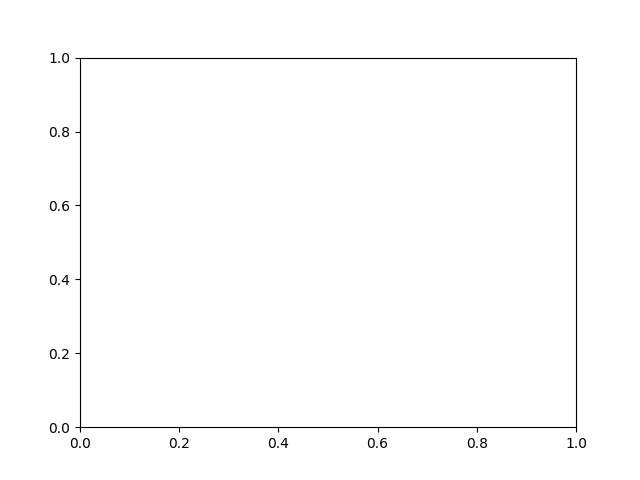

In [1]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()

%matplotlib ipympl

import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

def onclick(event):
    ix, iy = event.xdata, event.ydata
    print(ix, iy)

cid = fig.canvas.mpl_connect('button_press_event', onclick)


In [2]:
!pip install rasterio 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 52.3 MB/s eta 0:00:00


In [3]:
using_colab = True

In [4]:
if using_colab: 
  import numpy as np
  import torch
  import torchvision 
  print("PyTorch version:", torch.__version__)
  print("Torchvision version:", torchvision.__version__)  
  print("CUDA is available:", torch.cuda.is_available())
  import sys
  !{sys.executable} -m pip install opencv-python matplotlib
  !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  import matplotlib.pyplot as plt
  import cv2
  from skimage import measure, morphology
  import networkx as nx
  from shapely.geometry import Polygon, Point
  from tqdm import tqdm, trange
  import rasterio
  from rasterio.features import rasterize


PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-44odiryr
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-44odiryr
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=e4555867062728e213f37cc787223fb309459b9cf51e50cb725e19b52dbd0f40
  Stored in directory: /tmp/pip-ephem-wheel-cache-pbtz3p_8/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segm

In [5]:
# only run this once, when you need to download the model weights
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2023-05-01 17:50:41--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.162.103, 52.84.162.119, 52.84.162.20, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.162.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   104MB/s    in 18s     

2023-05-01 17:50:59 (135 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_mask_patch(mask, ax, random_color=True):
    contours = measure.find_contours(mask, 0.5)
    sx = contours[0][:,1]
    sy = contours[0][:,0]
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    patch = ax.fill(sx, sy, color=color, alpha=0.5)
    poly = Polygon(contours[0][:,::-1])
    return poly
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    
def find_overlapping_polygons(polygons, min_overlap_area):
    overlapping_polygons = []
    overlap_areas = []
    for i, poly1 in tqdm(enumerate(polygons)):
        for j, poly2 in enumerate(polygons):
            if not poly1.is_valid:
                poly1 = poly1.buffer(0)
            if not poly2.is_valid:
                poly2 = poly2.buffer(0)
            if i != j and poly1.intersects(poly2) and poly1.intersection(poly2).area > min_overlap_area:
                overlapping_polygons.append((i, j))
                overlap_areas.append(poly1.intersection(poly2).area)
    return overlapping_polygons, overlap_areas

def onclick(event):
    x, y = event.xdata, event.ydata
    if event.button == 1: # left mouse button for object
        coords.append((x, y))
        input_point = np.array([[coords[-1][0], coords[-1][1]]])
        input_label = np.array([1])
        masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True,
        )
        ind = np.argmax(scores)
        if np.sum(masks[ind])/(image.shape[0]*image.shape[1]) > 0.1:
            scores = np.delete(scores, ind)
            ind = np.argmax(scores)
        contours = measure.find_contours(masks[ind], 0.5)
        sx = contours[0][:,1]
        sy = contours[0][:,0]
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        ax.fill(sx, sy, facecolor='g', edgecolor='k', alpha=0.5)
        poly = Polygon(contours[0][:,::-1])
        ax.figure.canvas.draw()
    if event.button == 3: # right mouse button for background
        ax.patches[-1].remove()
        coords.append((x, y))
        input_point = np.array([[coords[-2][0], coords[-2][1]], [coords[-1][0], coords[-1][1]]])
        input_label = np.array([1, 0])
        masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True,
        )
        ind = np.argmax(scores)
        if np.sum(masks[ind])/(image.shape[0]*image.shape[1]) > 0.1:
            scores = np.delete(scores, ind)
            ind = np.argmax(scores)
        contours = measure.find_contours(masks[ind], 0.5)
        sx = contours[0][:,1]
        sy = contours[0][:,0]
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        ax.fill(sx, sy, facecolor='g', edgecolor='k', alpha=0.5)
        poly = Polygon(contours[0][:,::-1])
        ax.figure.canvas.draw() 
        
def onpress(event):
    sys.stdout.flush()
    if event.key == 'x': # delete last polygon
        ax.patches[-1].remove()
        fig.canvas.draw()
    if event.key == 'm': # merge last two polygons
        path1 = ax.patches[-1].get_path()
        path2 = ax.patches[-2].get_path()
        poly = Polygon(path1.vertices).union(Polygon(path2.vertices))
        ax.patches[-1].remove()
        ax.patches[-1].remove()
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        ax.fill(poly.exterior.xy[0], poly.exterior.xy[1], facecolor='g', edgecolor='k', alpha=0.5)
        fig.canvas.draw()

def onclick2(event):
    x, y = event.xdata, event.ydata
    point = Point(x, y)
    for i in range(len(all_grains)):
        if all_grains[i].contains(point):
            grain_inds.append(i)
            ax.fill(all_grains[i].exterior.xy[0], all_grains[i].exterior.xy[1], color='r', alpha=0.5)
            ax.figure.canvas.draw()

def onpress2(event):
    sys.stdout.flush()
    if event.key == 'x': # delete last polygon
        ax.patches[-1].remove()
        ax.patches[grain_inds[-1]].remove()
        all_grains.remove(all_grains[grain_inds[-1]])
        fig.canvas.draw()
    if event.key == 'm': # merge last two polygons
        path1 = ax.patches[-1].get_path()
        path2 = ax.patches[-2].get_path()
        poly = Polygon(path1.vertices).union(Polygon(path2.vertices))
        poly = poly.buffer(10).buffer(-10)
        ax.patches[-1].remove()
        ax.patches[-1].remove()
        ax.patches[grain_inds[-1]].remove()
        if grain_inds[-2] < grain_inds[-1]:
            ax.patches[grain_inds[-2]].remove()
        else:
            ax.patches[grain_inds[-2]-1].remove()
        all_grains.remove(all_grains[grain_inds[-1]])
        if grain_inds[-2] < grain_inds[-1]:
            all_grains.remove(all_grains[grain_inds[-2]])
        else:
            all_grains.remove(all_grains[grain_inds[-2]-1])
        all_grains.append(poly)  # add merged polygon to 'all_grains'
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        ax.fill(poly.exterior.xy[0], poly.exterior.xy[1], 
                facecolor=color, edgecolor='k', linewidth=2, alpha=0.5)
        fig.canvas.draw()

In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Single prompt segmentation

Click on one object at a time to generate a mask.

If you want to delete what was generated, press 'x'.

If you want to merge the last two objects that were clicked, press 'm'.

If you want to (try to) split part of the mask from what was generated, right click on the part that should not be part of the object.

In [9]:
fname = '/content/drive/MyDrive/SeaIce/0723_FL0_SC_p10/UF168_145337_168_UL006_144821_RGBN.tif'
image = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)

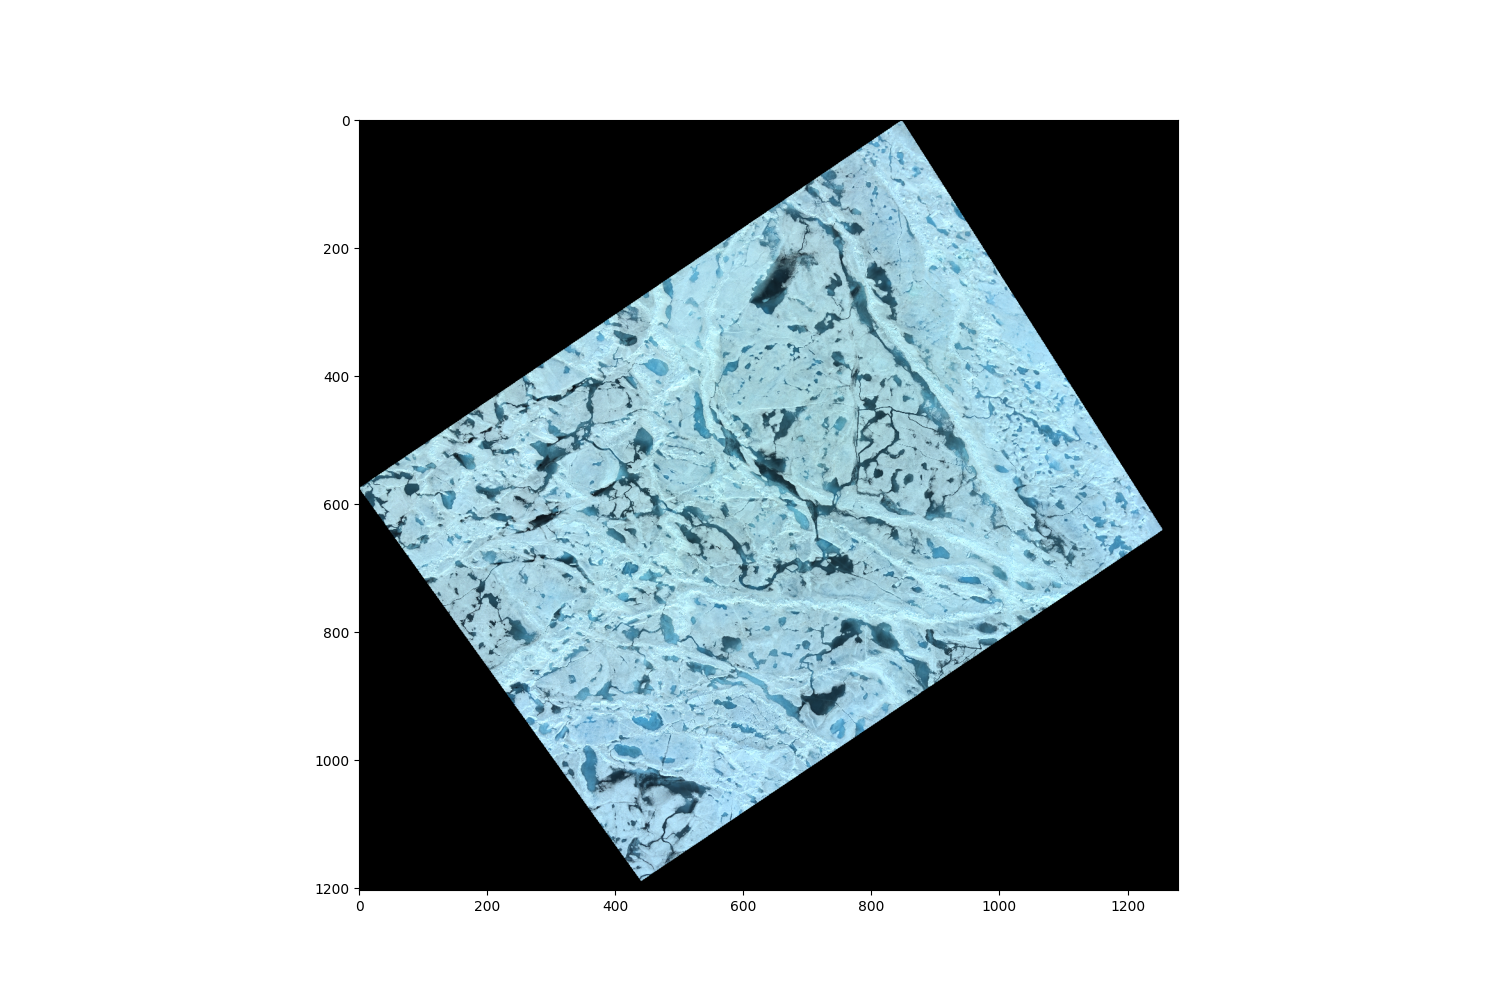

In [10]:
predictor = SamPredictor(sam)
predictor.set_image(image)

# plot interactive image
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(image)
coords = []
cid1 = fig.canvas.mpl_connect('button_press_event', onclick)
cid2 = fig.canvas.mpl_connect('key_press_event', onpress)
plt.show()

In [11]:
# this is how you can access all the object outlines:
for i in range(len(ax.patches)):
    x = ax.patches[i].get_path().vertices[:,0]
    y = ax.patches[i].get_path().vertices[:,1]
    plt.plot(x, y, 'r')

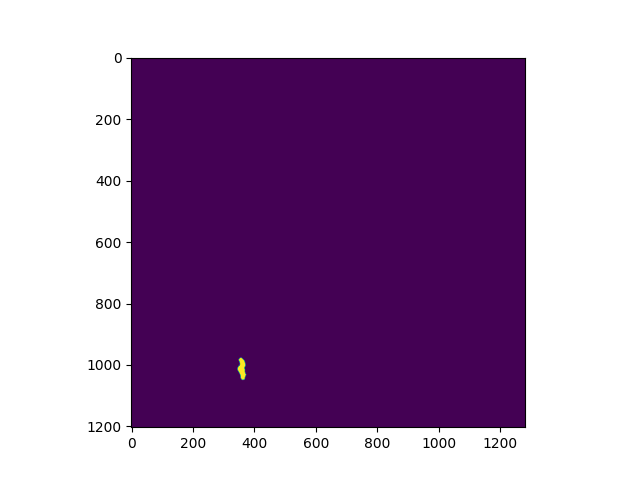

In [12]:
# for QCing masks from individual prompts
input_point = np.array([[coords[-1][0], coords[-1][1]]])
input_label = np.array([1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
plt.figure()
plt.imshow(masks[0]) ### 0,1,2 can go through mask layers

100%|██████████| 6/6 [00:00<00:00, 137.60it/s]


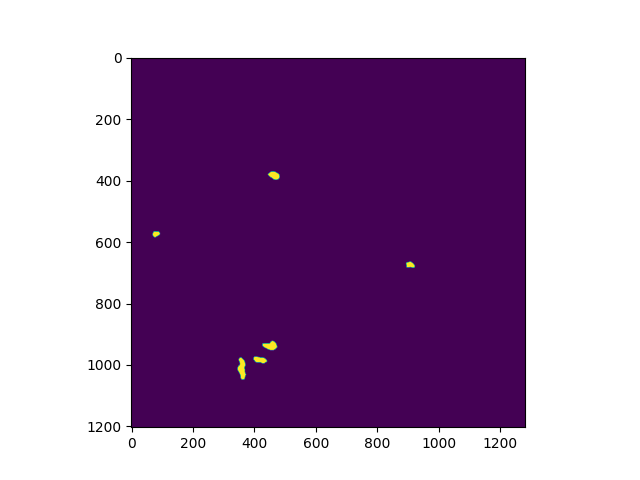

In [13]:
all_ponds = []
for i in range(len(ax.patches)):
    x = ax.patches[i].get_path().vertices[:,0]
    y = ax.patches[i].get_path().vertices[:,1]
    all_ponds.append(Polygon(np.vstack((x, y)).T))
    
# create labeled image
labels = np.zeros(image.shape[:-1])
for i in trange(len(all_ponds)):
    mask = rasterize(
        shapes=[all_ponds[i]],
        out_shape=image.shape[:-1],
        fill=0,
        out=None,
        transform=rasterio.Affine(1.0, 0.0, 0.0,
           0.0, 1.0, 0.0),
        all_touched=False,
        default_value=1,
        dtype=None,
    )
    labels[(mask==1) & (labels==0)] = i+1
    
labels[labels > 0] = 1 # if you want to set all objects to 1
plt.figure()
plt.imshow(labels)


## Segment everything

This can take a long time, especially if you are not using the GPU!

In [ ]:
mask_generator = SamAutomaticMaskGenerator(
  model=sam,
  points_per_side=32,
  pred_iou_thresh=0.86,
  stability_score_thresh=0.92,
  crop_n_layers=1,
  crop_n_points_downscale_factor=2,
  min_mask_region_area=20,
)

masks = mask_generator.generate(image)

for mask in tqdm(masks):
    # Label the objects in the binary image
    labeled_image, num_labels = measure.label(mask['segmentation'], return_num=True)
    # Find the object with the largest area
    label_counts = np.bincount(labeled_image.ravel())
    largest_label = np.argmax(label_counts[1:]) + 1
    mask['segmentation'][labeled_image != largest_label] = 0

overlap_threshold = 100
min_area = 20

all_grains = []
for mask in tqdm(masks):
    contours = measure.find_contours(mask['segmentation'], 0.5)
    sx = contours[0][:,1]
    sy = contours[0][:,0]
    all_grains.append(Polygon(contours[0][:,::-1]))

overlapping_polygons, overlap_areas = find_overlapping_polygons(all_grains, overlap_threshold)

g = nx.Graph(overlapping_polygons)
comps = list(nx.connected_components(g))

connected_grains = set()
for comp in comps:
    connected_grains.update(comp)

for j in trange(len(comps)):
    comb_masks_all = np.zeros((image.shape[0], image.shape[1]))
    count = 1
    for i in comps[j]:
        comb_masks_all += masks[i]['segmentation']*count
        count += 1
    for i in np.unique(comb_masks_all):
        if i != 0:
            if len(comb_masks_all[comb_masks_all == i]) > overlap_threshold:
                new_mask = np.zeros(np.shape(comb_masks_all))
                new_mask[comb_masks_all == i] = 1
                # Label the objects in the binary image
                labeled_image, num_labels = measure.label(new_mask, return_num=True)
                # Find the object with the largest area
                label_counts = np.bincount(labeled_image.ravel())
                largest_label = np.argmax(label_counts[1:]) + 1
                new_mask[labeled_image != largest_label] = 0
                # Define a disk-shaped structuring element with radius 3
                selem = morphology.disk(3)
                # Erode the image using the structuring element
                new_mask = morphology.binary_erosion(new_mask, selem)
                # Dilate the eroded image using the same structuring element
                new_mask = morphology.binary_dilation(new_mask, selem)
                if np.max(new_mask):
                    contours = measure.find_contours(new_mask, 0.5)
                    sx = contours[0][:,1]
                    sy = contours[0][:,0]
                    all_grains.append(Polygon(contours[0][:,::-1]))
                    
all_grains_new = []
for i in range(len(all_grains)):
    if i not in connected_grains and all_grains[i].area > min_area:
        all_grains_new.append(all_grains[i])
all_grains = all_grains_new

  0%|          | 0/3 [00:00<?, ?it/s]


IndexError: ignored

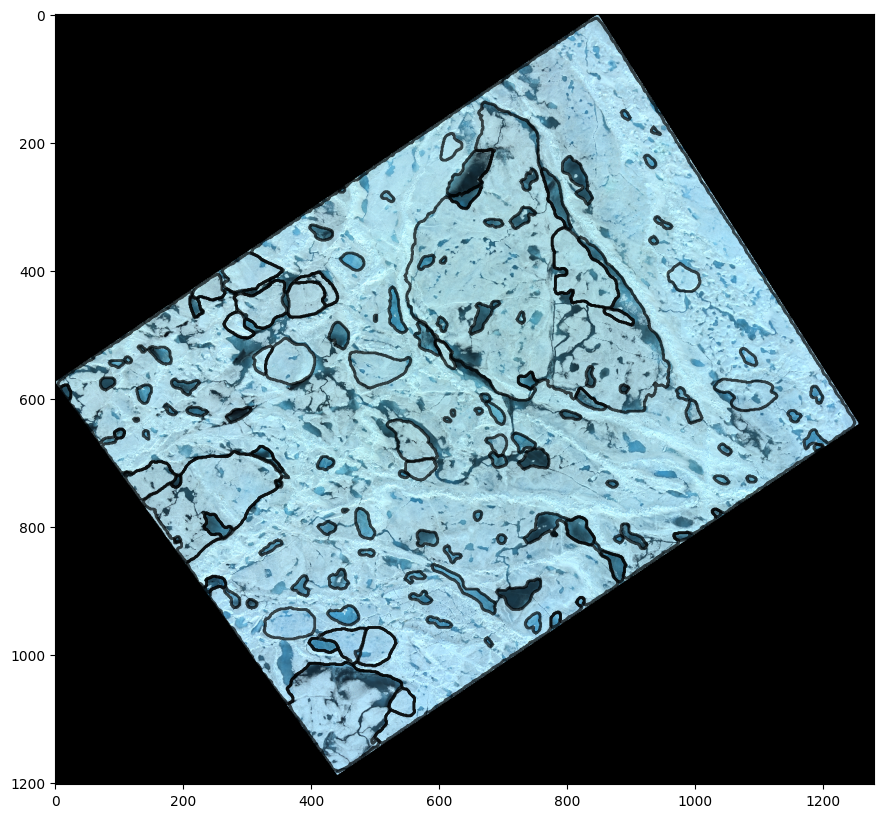

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(image)
for i in range(len(all_grains)):
    ax.fill(all_grains[i].exterior.xy[0], all_grains[i].exterior.xy[1], 
            facecolor='none', edgecolor='k', linewidth=2, alpha=0.7)

global grain_inds
grain_inds = []
cid1 = fig.canvas.mpl_connect('button_press_event', onclick2)
cid2 = fig.canvas.mpl_connect('key_press_event', onpress2)

In [ ]:
# create labeled image
labels = np.zeros(image.shape[:-1])
for i in trange(len(all_grains)):
    mask = rasterize(
        shapes=[all_grains[i]],
        out_shape=image.shape[:-1],
        fill=0,
        out=None,
        transform=rasterio.Affine(1.0, 0.0, 0.0,
           0.0, 1.0, 0.0),                         ## proper transfrom here
        all_touched=False,
        default_value=1,
        dtype=None,
    )
    labels[mask==1] = i+1 ## could change to =1 to make binary raster
plt.figure()
plt.imshow(labels)

NameError: ignored

In [ ]:
from skimage.measure import regionprops, regionprops_table
import pandas as pd
props = regionprops_table(labels.astype('int'), intensity_image = image, properties =\
        ('label', 'area', 'centroid', 'major_axis_length', 'minor_axis_length', 
         'orientation', 'perimeter', 'max_intensity', 'mean_intensity', 'min_intensity'))
object_data = pd.DataFrame(props)

In [ ]:
object_data

label    area  centroid-0   centroid-1  major_axis_length  \
0        4       6  823.333333   187.666667           3.651484   
1        6       6  680.166667  1191.833333           5.912062   
2       10      47  731.382979   348.446809           9.120214   
3       11       9  270.444444   447.111111           8.840162   
4       15     871    1.330654   566.959816         648.727046   
..     ...     ...         ...          ...                ...   
114    125     908  470.694934   667.686123          62.943831   
115    126     212  483.075472   604.792453          22.309703   
116    127    7579  402.221401   822.528566         143.263934   
117    128    1237  805.936944   819.337914          51.445805   
118    129  138299  990.946731   147.711061         637.615786   

     minor_axis_length  orientation    perimeter  max_intensity-0  \
0             2.108185    -0.785398     5.414214             93.0   
1             1.221464    -1.131067     5.414214             77.0   
2             7.107375     0.607129    25.692388            190.0   
3             1.431457    -0.935602     7.621320             88.0   
4             1.867068    -1.567553   870.207107              0.0   
..                 ...          ...          ...              ...   
114          23.773804    -0.573780   175.923882            186.0   
115          12.740761     0.361549    59.698485            165.0   
116          73.755583     0.649654   435.889394            202.0   
117          32.367552     0.751088   148.367532            184.0   
118         333.378303     0.484736  1864.247871              0.0   

     max_intensity-1  max_intensity-2  mean_intensity-0  mean_intensity-1  \
0              127.0            144.0         52.166667         82.000000   
1              144.0            180.0         69.333333        135.000000   
2              239.0            253.0         69.957447        115.787234   
3              155.0            177.0         26.777778         49.111111   
4                0.0              0.0          0.000000          0.000000   
..               ...              ...               ...               ...   
114            233.0            243.0         53.280837         97.819383   
115            212.0            218.0         69.589623        128.561321   
116            249.0            255.0        157.570260        202.972556   
117            237.0            252.0         57.386419        107.219887   
118              0.0              0.0          0.000000          0.000000   

     mean_intensity-2  min_intensity-0  min_intensity-1  min_intensity-2  
0           98.166667             35.0             62.0             76.0  
1          168.666667             61.0            124.0            157.0  
2          132.595745             38.0             76.0             89.0  
3           58.666667              0.0              0.0              0.0  
4            0.000000              0.0              0.0              0.0  
..                ...              ...              ...              ...  
114        113.125551             32.0             68.0             82.0  
115        147.518868             39.0             85.0             98.0  
116        212.969785             24.0             44.0             63.0  
117        126.479386             24.0             59.0             75.0  
118          0.000000              0.0              0.0              0.0  

[119 rows x 17 columns]